In [2]:
import numpy as np
import jointpdf as jp
import seaborn as sns
import scipy.stats as ss
from scipy.ndimage.filters import gaussian_filter1d
import multiprocessing as mp
import time

sns.set(font_scale=1.4)
sns.set_style('white')

In [3]:
reload(jp)

<module 'jointpdf' from '/home/rquax/PycharmProjects/syninfo/jointpdf.pyc'>

# Skewness of MI after a fixed-norm random nudge

In [4]:
# just some warming up of skills
pdf = jp.JointProbabilityMatrix(1, 2, 'uniform')
pdf.append_variables_with_target_mi_and_marginal(1, 0.9, marginal_probs=[ 0.484576, 0.515424 ])
print pdf.mutual_information([0], [1])
print pdf[0].joint_probabilities.joint_probabilities
print pdf[1].joint_probabilities.joint_probabilities
print pdf.joint_probabilities.joint_probabilities

0.899999935118
[ 0.5  0.5]
[ 0.48457598  0.51542402]
[[ 0.48457598  0.015424017]
 [ 0.0  0.5]]


In [5]:
# nudges, impacts = pdf.susceptibility_local_single(0, 1, nudge_method='random', impact_measure='prob')

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

ImportError: No module named plotly.plotly

In [315]:
# try to find a single pdf (X,Y) with I(X:Y)=f*H(X) and nudging it `ntrials` times, storing all results

numvals = 3
f = 0.6  # target MI as fraction of input (X) entropy
init_cond = 'uniform'
epsilon = 0.05
ntrials = 10000
nudge_method = 'random'

time_before = time.time()

# shape (A, B). 
# helper function
def cond_pdf_matrix(pdf):
    return [pdf.conditional_probability_distribution([0], [aix]).joint_probabilities.joint_probabilities
            for aix in xrange(pdf.numvalues)]

### CAUSAL IMPACT

success = False
for i in xrange(10):  # sometimes fails to find a pdf (even after trying 20 times)
    try:
        for j in xrange(20):
            pdf = jp.JointProbabilityMatrix(1, numvals, init_cond)
            
            if f > 0:
                pdf.append_variables_with_target_mi(1, f * pdf.entropy(), 
                                                    num_repeats=int((numvals - 1) / 2) + 1)
            else:
                pdf.append_independent_variables(pdf)
            
            if np.all(np.greater(cond_pdf_matrix(pdf), 0)):
                break
            else:
                print 'note: regenerate pdf to make cond_pdf with all nonzero elements'
                pass  # try again; nc_terms_2 divides by cond_pdf so there should be no zero in there

        

        nudge, impact, pdf_after = pdf.susceptibility_local_single(0, 1, epsilon, 
                                                                   impact_measure='prob', 
                                                                   ntrials=ntrials,
                                                                   also_return_pdf_after=True, 
                                                                   nudge_method=nudge_method)

        print 'note: finished causal after %s seconds' % (time.time() - time_before)

        ### NON-CAUSAL EFFECT

        pdf_nc = pdf.copy()
        pdf_nc.reorder_variables([1, 0])  # reverse order so that B causes A (and we nudge A)

        nudge_nc, impact_nc, pdf_after_nc = pdf_nc.susceptibility_local_single(1, 0, epsilon, 
                                                                               impact_measure='prob', 
                                                                               ntrials=ntrials,
                                                                               also_return_pdf_after=True,
                                                                               nudge_method=nudge_method)
        
        pdf_nc.reorder_variables([1, 0])  # reverse order again to bring back to (A, B)
        for pix in xrange(len(pdf_after_nc)):  # also reverse order again
            pdf_after_nc[pix].reorder_variables([1, 0])
        
    except UserWarning as e:
        print 'note: failed to find a suitable pdf and nudges for iteration %s' % i
        success = False
    else:
        success = True
    
    if success:
        break
    
### FURTHER CALCULATIONS

# for causal case only, since for non-causal case the impact would always be zero
impact_terms = np.sum(np.divide(np.power(impact, 2), pdf[1].joint_probabilities.joint_probabilities), axis=1)

# scalar:
mi_before = pdf.mutual_information([0], [1])
# the rest is a list of length `ntrials`
mi_after = [p.mutual_information([0], [1]) for p in pdf_after]
mi_after_nc = [p.mutual_information([0], [1]) for p in pdf_after_nc]
mi_diff = map(float, np.subtract(mi_after, mi_before))
mi_diff_nc = map(float, np.subtract(mi_after_nc, mi_before))

# $\\Delta_{b|a}$ is cond_pdf[a][b]  (see derivation notes in slides)
cond_pdf = cond_pdf_matrix(pdf)
# cond_pdf_after = [cond_pdf_matrix(p) for p in pdf_after]  # not useful as each of them is equal to cond_pdf
cond_pdf_after_nc = [cond_pdf_matrix(p) for p in pdf_after_nc]
# delta = np.subtract(cond_pdf_after, [cond_pdf]*len(pdf_after))
delta_nc = np.subtract(cond_pdf_after_nc, [cond_pdf]*len(pdf_after_nc))

assert np.max(np.sum(delta, axis=2)) < 0.00001, 'should be zero save some roundoff error'
assert np.max(np.sum(delta_nc, axis=2)) < 0.00001, 'should be zero save some roundoff error'

p_A = pdf[0].joint_probabilities.joint_probabilities  # store for efficiency
p_A_mat = [p_A]*len(delta)  # p(A) repeated in the form of 'nudge_nc'
p_B_mat = [[pdf[1].joint_probabilities.joint_probabilities]*pdf.numvalues]*len(delta)  # p(B) repeated in format of 'delta'
cond_pdf_mat = np.array([cond_pdf]*len(delta))  # p(B|A) repeated in the form of 'delta'

# intermediate computation
surprise_ratio_0is1 = np.divide(cond_pdf_mat, p_B_mat)
surprise_ratio_0is1[np.equal(cond_pdf_mat, 0)] = 1  # when enumerator is 0, make log term 0 otherwise I get error
cond_surprise = np.log2(surprise_ratio_0is1)  # $\sigma_{b|a}$ in the form of 'delta'
surprise = np.sum(cond_pdf_mat * surprise_ratio_0is1, axis=2)  # $\sigma_a$

# the terms from the analytical approximations
nc_terms_1 = np.sum(p_A_mat * np.sum(delta_nc * cond_surprise, axis=2), axis=1)  # weak correlations
nc_terms_2 = np.sum(p_A_mat * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
nc_terms_3 = np.sum(nudge_nc * np.sum(delta_nc * cond_surprise, axis=2), axis=1)
nc_terms_4 = np.sum(nudge_nc * surprise, axis=1)
nc_terms_5 = np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)

# nc_terms2 = np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / [cond_pdf]*len(pdf_after_nc), axis=2), axis=1)
# assert np.ndim(nc_terms2) == 1

# p_A = pdf[0].joint_probabilities.joint_probabilities  # store for efficiency
# p_B_mat = [[pdf[1].joint_probabilities.joint_probabilities]*pdf.numvalues]*len(delta)  # p(B) repeated in format of 'delta'
# assert np.size(p_B_mat) == np.count_nonzero(p_B_mat), 'must re-implement log-term below to handle 0s! or replace with 1'
# # cond_pdf_0is1 is created to prevent errors in np.log2, which assumes that if p(b|a)=0 then also
# # delta(b|a) should be 0, which I am not sure about (anyway p(b|a)=0 never happens when generating random pdfs)
# cond_pdf_0is1 = np.array(cond_pdf).copy()
# cond_pdf_0is1[cond_pdf_0is1 == 0] = 1
# nc_terms3 = np.sum(np.multiply([p_A]*len(pdf_after_nc), 
#                                np.sum(delta_nc * np.subtract(np.log2([cond_pdf_0is1]*len(pdf_after_nc)), np.log2(p_B_mat)), axis=2)), 
#                    axis=1)
# assert np.ndim(nc_terms3) == 1

note: regenerate pdf to make cond_pdf with all nonzero elements
note: finished causal after 96.9161331654 seconds


In [115]:
end_figname = '3'  # identify different outputs even if using the exact same parameter values

In [116]:
def figname(firstpart, end=end_figname):
    if end is None:
        return './figures/%s_nv%s_f%s_ntrials%s_init-%s_nudge-%s_eps%s.png' % (firstpart, numvals, f, ntrials, init_cond, nudge_method, epsilon)
    else:
        return './figures/%s_nv%s_f%s_ntrials%s_init-%s_nudge-%s_eps%s_%s.png' % (firstpart, numvals, f, ntrials, init_cond, nudge_method, epsilon, end)

In [355]:
p_A = pdf[0].joint_probabilities.joint_probabilities  # store for efficiency
p_A_mat = [p_A]*len(delta)  # p(A) repeated in the form of 'nudge_nc'
p_B_mat = [[pdf[1].joint_probabilities.joint_probabilities]*pdf.numvalues]*len(delta)  # p(B) repeated in format of 'delta'
cond_pdf_mat = np.array([cond_pdf]*len(delta))  # p(B|A) repeated in the form of 'delta'

# intermediate computation
surprise_ratio_0is1 = np.divide(cond_pdf_mat, p_B_mat)
surprise_ratio_0is1[np.equal(cond_pdf_mat, 0)] = 1  # when enumerator is 0, make log term 0 otherwise I get error
cond_surprise = np.log2(surprise_ratio_0is1)  # $\sigma_{b|a}$ in the form of 'delta'
# surprise = np.sum(np.log2(cond_pdf_mat * surprise_ratio_0is1), axis=2)  # $\sigma_a$
surprise = np.sum(cond_pdf_mat * surprise_ratio_0is1, axis=2)  # $\sigma_a$

# the terms from the analytical approximations (new)
nc_terms_1 = np.sum(p_A_mat * np.sum(delta_nc * cond_surprise, axis=2), axis=1)  #wrong
nc_terms_2 = np.sum(p_A_mat * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
nc_terms_3 = np.sum(nudge_nc * np.sum(delta_nc * cond_surprise, axis=2), axis=1)
nc_terms_4 = np.sum(nudge_nc * surprise, axis=1)
nc_terms_5 = np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)

In [317]:
cond_pdf

[array([ 0.97192862,  0.005892,  0.022179382], dtype=float128),
 array([ 0.22350014,  0.74906806,  0.027431795], dtype=float128),
 array([ 0.045814406,  0.089245674,  0.86493992], dtype=float128)]

In [318]:
print np.shape(np.power(delta_nc, 2) / cond_pdf_mat)
x_terms = np.power(delta_nc, 2) / cond_pdf_mat
print np.percentile(x_terms, 50), np.percentile(x_terms, 75), np.percentile(x_terms, 95), '(should preferably all <=1)'

(10000, 3, 3)
0.0010150653001 0.00444225701913 0.0320667454706 (should preferably all <=1)


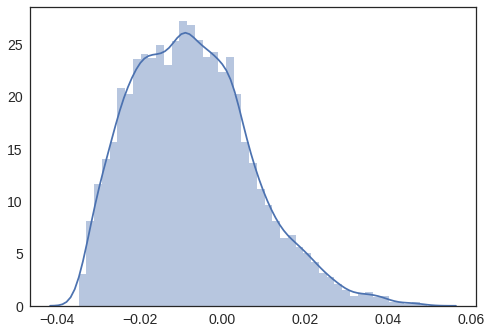

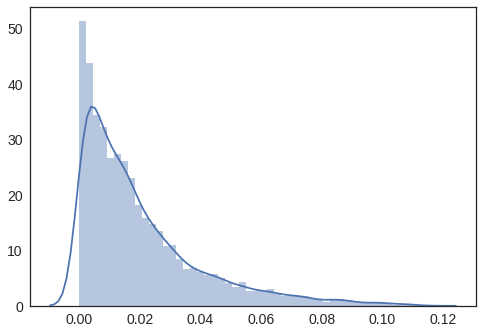

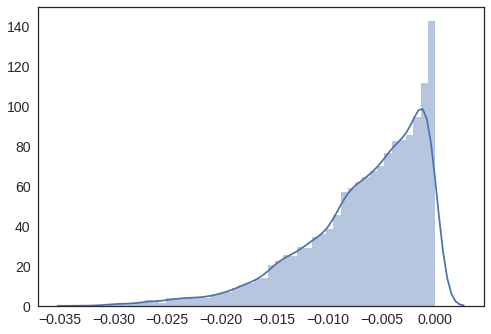

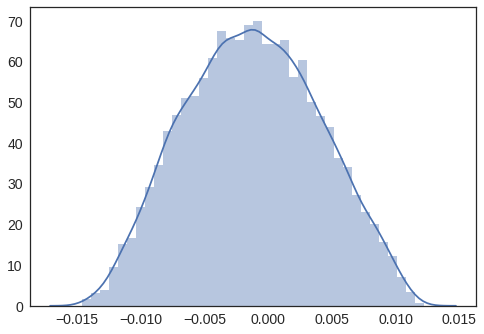

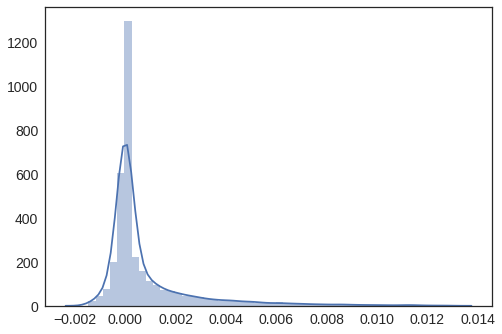

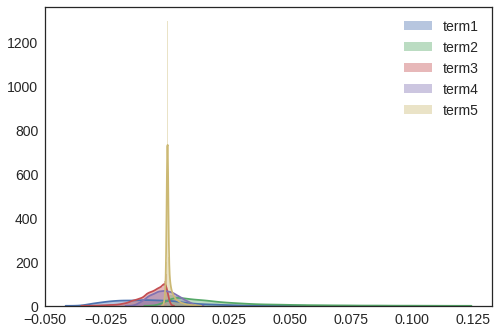

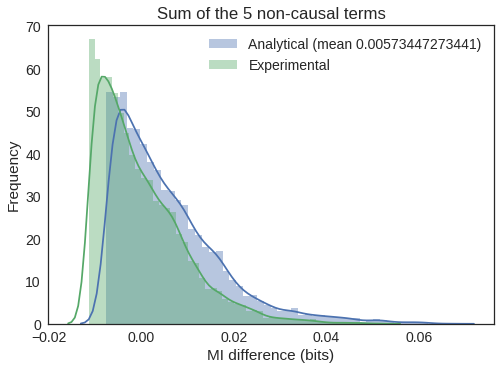

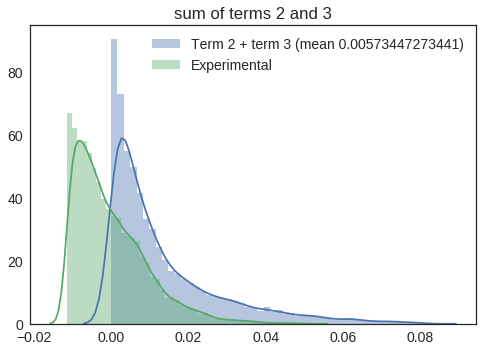

In [364]:
sns.distplot(map(float, nc_terms_1))
sns.plt.show()
sns.distplot([f for f in map(float, nc_terms_2) if np.isfinite(f)])
sns.plt.show()
sns.distplot(map(float, nc_terms_3))
sns.plt.show()
sns.distplot(map(float, nc_terms_4))
sns.plt.show()
sns.distplot(map(float, nc_terms_5))
sns.plt.show()

sns.distplot(map(float, nc_terms_1), label='term1')
sns.distplot([f for f in map(float, nc_terms_2) if not np.isnan(f)], label='term2')
sns.distplot(map(float, nc_terms_3), label='term3')
sns.distplot(map(float, nc_terms_4), label='term4')
sns.distplot(map(float, nc_terms_5), label='term5')
sns.plt.legend()
sns.plt.show()

actual_mean = np.mean(nc_terms_1 + nc_terms_2 + nc_terms_3 + nc_terms_4 + nc_terms_5)
sns.distplot(map(float, nc_terms_1 + nc_terms_2 + nc_terms_3 + nc_terms_4 + nc_terms_5), label='Analytical (mean %s)' % actual_mean, norm_hist=True)
sns.distplot(mi_diff_nc, label='Experimental', norm_hist=True)
sns.plt.legend()
sns.plt.title('Sum of the 5 non-causal terms')
sns.plt.xlabel('MI difference (bits)')
sns.plt.ylabel('Frequency')
sns.plt.savefig(figname('noncausal_mi_diff'))
sns.plt.show()

sns.distplot(map(float, nc_terms_2 + nc_terms_3), label='Term 2 + term 3 (mean %s)' % actual_mean, norm_hist=True)
sns.distplot(mi_diff_nc, label='Experimental', norm_hist=True)
sns.plt.legend()
sns.plt.title('sum of terms 2 and 3')
sns.plt.show()

In [384]:
np.prod([1,2,3])

6

In [391]:
print np.reshape(delta_nc, (np.prod(np.shape(delta_nc)),))[:10]
print np.reshape(cond_surprise, (np.prod(np.shape(cond_surprise)),))[:10]

[-0.013944152  0.0068826294  0.0070615231 -0.015113345  0.037151588
 -0.022038243  0.016842721  0.0087962514 -0.025638973 -0.014352457]
[ 1.232099 -5.5777309 -3.7808102 -0.88847562  1.4124647 -3.4741803
 -3.1748782 -1.656778  1.5044986  1.232099]


note: correlation nc_terms_2 and nc_terms_3: (-0.94830470221611884, 0.0)
note: correlation delta_nc and cond_surprise: (-0.050423307255875238, 9.3161844600720957e-52)
note: correlation delta_nc and cond_pdf: (-0.018644964080481, 2.2202775087549916e-08)
note: correlation p(A) and np.sum(delta_nc * cond_surprise, axis=2): (-0.094506377981986536, 1.7604279406685521e-60)


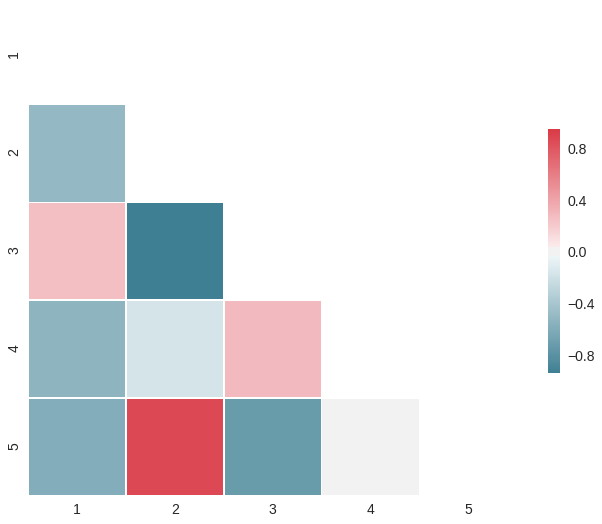

In [410]:
print 'note: correlation nc_terms_2 and nc_terms_3:', ss.pearsonr(map(float, nc_terms_2), map(float, nc_terms_3))
print 'note: correlation delta_nc and cond_surprise:', ss.pearsonr(map(float, np.reshape(delta_nc, (np.prod(np.shape(delta_nc)),))), map(float, np.reshape(cond_surprise, (np.prod(np.shape(cond_surprise)),))))
print 'note: correlation delta_nc and cond_pdf:', ss.pearsonr(map(float, np.reshape(delta_nc, (np.prod(np.shape(delta_nc)),))), map(float, np.reshape(cond_pdf_mat, (np.prod(np.shape(cond_pdf_mat)),))))
print 'note: correlation p(A) and np.sum(delta_nc * cond_surprise, axis=2):', ss.pearsonr(map(float, np.reshape(p_A_mat, (np.prod(np.shape(p_A_mat)),))), map(float, np.reshape(np.sum(delta_nc * cond_surprise, axis=2), (np.prod(np.shape(np.sum(delta_nc * cond_surprise, axis=2))),))))

corr = np.corrcoef([nc_terms_1, nc_terms_2, nc_terms_3, nc_terms_4, nc_terms_5])

def plot_corrmat(corr, figname_start='corrmat', ticklabels=None):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = sns.plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    if ticklabels is None:
        ticklabels = range(1, len(corr)+1)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, xticklabels=ticklabels, yticklabels=ticklabels,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

    if not figname_start is None:
        sns.plt.savefig(figname(figname_start))

    sns.plt.show()
    
plot_corrmat(corr, 'corrmat_nc_terms')

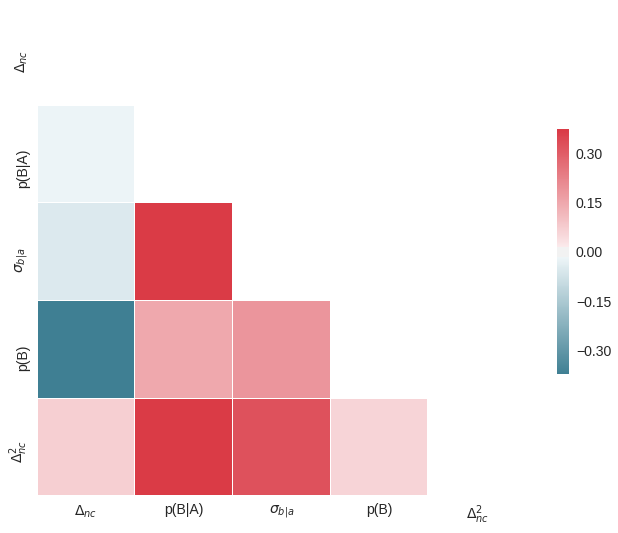

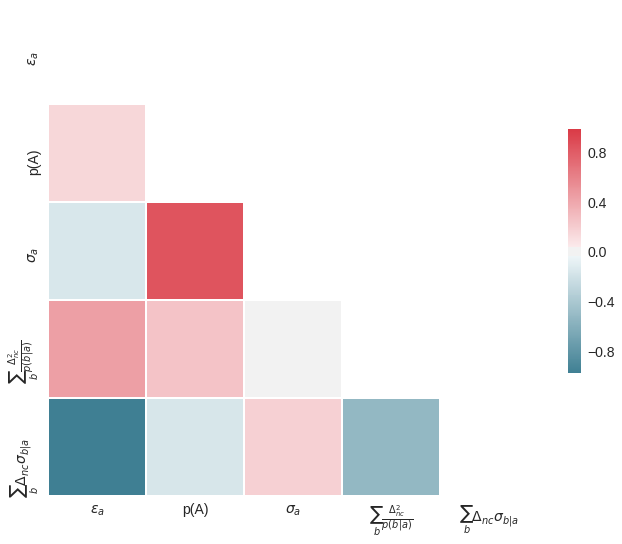

In [418]:
inner_terms = map(lambda x: np.reshape(x, (np.prod(np.shape(x)),)), [delta_nc, cond_pdf_mat, cond_surprise, p_B_mat, np.power(delta_nc, 2)])
outer_terms = map(lambda x: np.reshape(x, (np.prod(np.shape(x)),)), [nudge_nc, p_A_mat, surprise, np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), np.sum(delta_nc * cond_surprise, axis=2)])

corr = np.corrcoef(inner_terms)

plot_corrmat(corr, 'corrmat_nc_innerterms', ['$\\Delta_{nc}$', 'p(B|A)', '$\\sigma_{b|a}$', 'p(B)', '$\\Delta_{nc}^2$'])

corr = np.corrcoef(outer_terms)

plot_corrmat(corr, 'corrmat_nc_outerterms', ['$\\epsilon_{a}$', 'p(A)', '$\\sigma_{a}$', '$\\sum_b \\frac{\\Delta_{nc}^2}{p(b|a)}$', '$\\sum_b \\Delta_{nc} \\sigma_{b|a}$'])

In [ ]:
# nc_terms_1 = np.sum(p_A_mat * np.sum(delta_nc * cond_surprise, axis=2), axis=1)  #wrong
# nc_terms_2 = np.sum(p_A_mat * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
# nc_terms_3 = np.sum(nudge_nc * np.sum(delta_nc * cond_surprise, axis=2), axis=1)
# nc_terms_4 = np.sum(nudge_nc * surprise, axis=1)
# nc_terms_5 = np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)

The five terms for non-causal nudges are:

 1. $\sum_a p_a \sum_b \Delta_{b|a} \cdot \sigma_{b|a}$
 2. $\sum_a p_a \sum_b \frac{\Delta_{b|a}^2}{p(b|a)}$
 3. $\sum_a \epsilon_a \sum_b \Delta_{b|a} \cdot \sigma_{b|a}$
 4. $\sum_a \epsilon_a \sigma_a$
 5. $\sum_a \epsilon_a \sum_b \frac{\Delta_{b|a}^2}{p(b|a)}$

The above two correlation plots show that there is no or only a modest amount of correlation between sub-terms in the 5 non-causal terms. This can help explain why some of the terms are symmetric and centered around zero (term1, term4) whereas others are right-skewed (term2, probably due to strong correlation between $\Delta_{b|a}^2$ and $p(b|a)$ [actually irrelevant?] and weak positive correlation between $p_a$ and $\sum_b \frac{\Delta_{b|a}^2}{p(b|a)}$; term5, same strong correlation [actually irrelevant?] and similar weak positive correlation between $\epsilon_a$ and $\sum_b \frac{\Delta_{b|a}^2}{p(b|a)}$) and others are left-skewed (term3; probably due to strong negative correlation between $\epsilon_a$ and $\sum_b \Delta_{nc} \sigma_{b|a}$ -- see plot below to see this). 

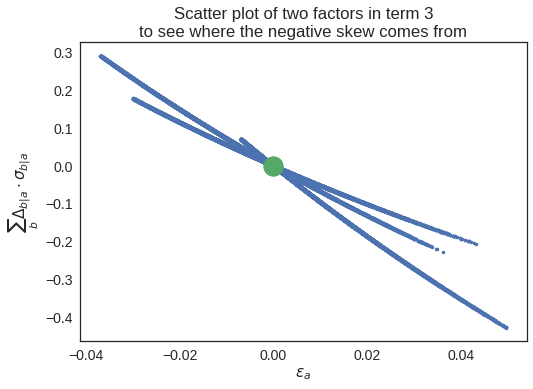

In [452]:
sns.plt.plot(np.reshape(nudge_nc, (np.prod(np.shape(nudge_nc)),)), np.reshape(np.sum(delta_nc * cond_surprise, axis=2), (np.prod(np.shape(np.sum(delta_nc * cond_surprise, axis=2))),)), '.')
sns.plt.plot([0, 0], [0, 0], 'o', markersize=20)
sns.plt.xlabel('$\\epsilon_a$')
sns.plt.ylabel('$\\sum_b \\Delta_{b|a} \\cdot \\sigma_{b|a}$')
sns.plt.title('Scatter plot of two factors in term 3\nto see where the negative skew comes from')
sns.plt.show()

True
(10000,)


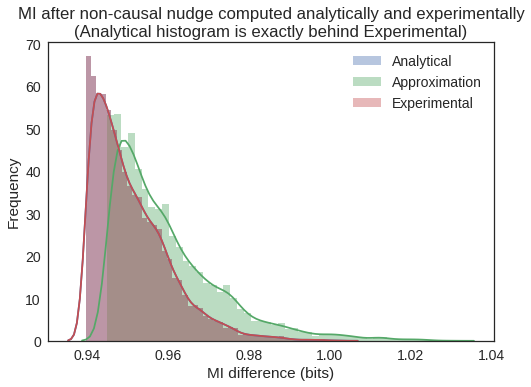

In [455]:
# try to pinpoint where the analytical derivation goes wrong... step by step
# Found it!

mi_after_analytical = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * np.log2(cond_pdf_mat / p_B_mat * (1. + delta_nc / cond_pdf_mat)), axis=2), axis=1)
# the next one is exactly equivalent which is good:
mi_after_analytical2 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * np.log2((cond_pdf_mat + delta_nc) / p_B_mat), axis=2), axis=1)
# still ok:
mi_after_analytical3 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * (np.log2(cond_pdf_mat / p_B_mat) + np.log2(1. + delta_nc / cond_pdf_mat)), axis=2), axis=1)
# good approximation:
mi_after_analytical4 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * (np.log2(cond_pdf_mat / p_B_mat) + delta_nc / cond_pdf_mat), axis=2), axis=1)
mi_after_analytical5 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) + np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * delta_nc / cond_pdf_mat, axis=2), axis=1)
# exact transformation (leave out term cond_pdf_mat)
mi_after_analytical6 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) + np.sum(np.add(p_A_mat, nudge_nc) * np.sum((delta_nc) * delta_nc / cond_pdf_mat, axis=2), axis=1)
mi_after_analytical6 = np.sum(np.add(p_A_mat, nudge_nc) * np.sum((cond_pdf_mat + delta_nc) * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) + np.sum(np.add(p_A_mat, nudge_nc) * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
mi_after_analytical6 = \
np.sum(p_A_mat * np.sum(cond_pdf_mat * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(p_A_mat * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(cond_pdf_mat * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(np.add(p_A_mat, nudge_nc) * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
# substitute the original I(A:B):
mi_after_analytical6 = \
mi_before \
+ np.sum(p_A_mat * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(cond_pdf_mat * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(np.add(p_A_mat, nudge_nc) * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
# final split of a sum
mi_after_analytical6 = \
mi_before \
+ np.sum(p_A_mat * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(cond_pdf_mat * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(p_A_mat * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)
# insert surprise
surprise_a = np.sum(cond_pdf_mat * np.log2(cond_pdf_mat / p_B_mat), axis=2)
mi_after_analytical6 = \
mi_before \
+ np.sum(p_A_mat * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(nudge_nc * surprise_a, axis=1) \
+ np.sum(nudge_nc * np.sum(delta_nc * np.log2(cond_pdf_mat / p_B_mat), axis=2), axis=1) \
+ np.sum(p_A_mat * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1) \
+ np.sum(nudge_nc * np.sum(np.power(delta_nc, 2) / cond_pdf_mat, axis=2), axis=1)

print np.all(np.isfinite(mi_after_analytical))
print np.shape(mi_after_analytical)

sns.distplot(map(float, mi_after_analytical), label='Analytical')
sns.distplot(map(float, mi_after_analytical6), label='Approximation')
sns.plt.title('MI after non-causal nudge computed analytically and experimentally\n(Analytical histogram is exactly behind Experimental)')
# sns.plt.show()
sns.distplot(map(float, mi_after_nc), label='Experimental')
sns.plt.xlabel('MI difference (bits)')
sns.plt.ylabel('Frequency')
sns.plt.legend()
# sns.plt.title('MI after non-causal nudge computed experimentally')
sns.plt.show()

In [286]:
print np.max(impact)
print np.max(impact_nc)
print np.mean(np.linalg.norm(nudge, axis=1)), '(should equal epsilon)'
print np.mean(np.linalg.norm(nudge_nc, axis=1)), '(should equal epsilon)'

0.0465753918372
0.0
0.035458447164 (should equal epsilon)
0.0333874737609 (should equal epsilon)


In [111]:
mi_skews = [ss.skew(np.random.choice(mi_diff, replace=True, size=len(mi_diff))) for _ in xrange(1000)]
mi_skews_nc = [ss.skew(np.random.choice(mi_diff_nc, replace=True, size=len(mi_diff_nc))) for _ in xrange(1000)]

print 'note: the 95%% CI for causal MI skewness is: (%s, %s)' % (np.percentile(mi_skews, 2.5), np.percentile(mi_skews, 97.5))
print 'note: the 95%% CI for non-causal MI skewness is: (%s, %s)' % (np.percentile(mi_skews_nc, 2.5), np.percentile(mi_skews_nc, 97.5))

note: the 95% CI for causal MI skewness is: (-0.759640236419, -0.695052179368)
note: the 95% CI for non-causal MI skewness is: (1.06160942538, 1.15168361129)


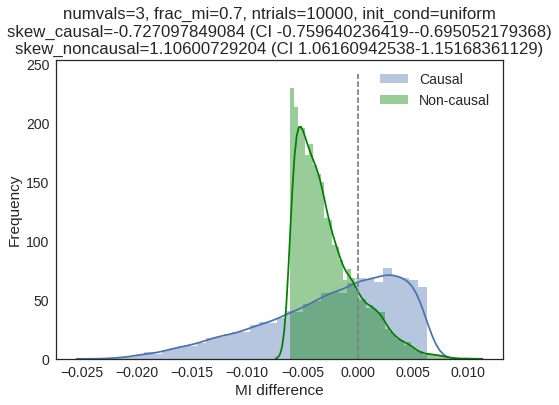

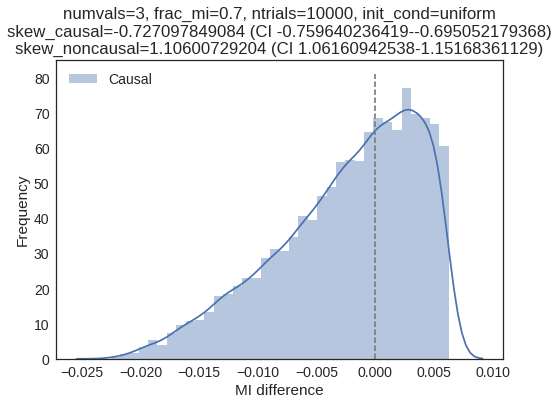

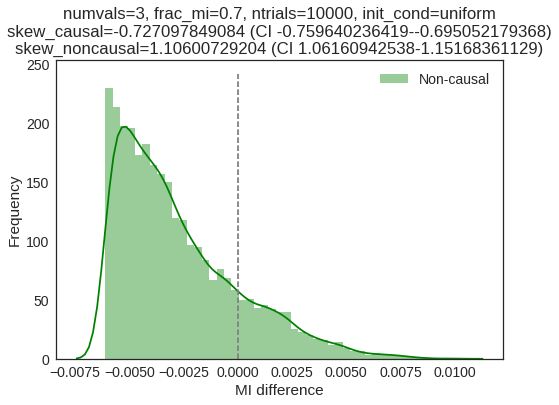

In [212]:
sns.distplot(mi_diff, label='Causal')
sns.distplot(mi_diff_nc, label='Non-causal', color='g')
sns.plt.xlabel('MI difference')
sns.plt.ylabel('Frequency')
sns.plt.title('numvals=%s, frac_mi=%s, ntrials=%s, init_cond=%s\nskew_causal=%s (CI %s-%s)\nskew_noncausal=%s (CI %s-%s)' % (numvals, f, ntrials, init_cond, ss.skew(mi_diff), np.percentile(mi_skews, 2.5), np.percentile(mi_skews, 97.5), ss.skew(mi_diff_nc), np.percentile(mi_skews_nc, 2.5), np.percentile(mi_skews_nc, 97.5)))
sns.plt.legend()
sns.plt.plot([0, 0], sns.plt.ylim(), '--', color='0.5')
sns.plt.savefig(figname('dist_mi_diff'))
sns.plt.show()

sns.distplot(mi_diff, label='Causal')
# sns.distplot(mi_diff_nc, label='Non-causal')
sns.plt.xlabel('MI difference')
sns.plt.ylabel('Frequency')
sns.plt.title('numvals=%s, frac_mi=%s, ntrials=%s, init_cond=%s\nskew_causal=%s (CI %s-%s)\nskew_noncausal=%s (CI %s-%s)' % (numvals, f, ntrials, init_cond, ss.skew(mi_diff), np.percentile(mi_skews, 2.5), np.percentile(mi_skews, 97.5), ss.skew(mi_diff_nc), np.percentile(mi_skews_nc, 2.5), np.percentile(mi_skews_nc, 97.5)))
sns.plt.legend()
sns.plt.plot([0, 0], sns.plt.ylim(), '--', color='0.5')
sns.plt.savefig(figname('dist_mi_diff_causal'))
sns.plt.show()

# sns.distplot(mi_diff, label='Causal')
sns.distplot(mi_diff_nc, label='Non-causal', color='g')
sns.plt.xlabel('MI difference')
sns.plt.ylabel('Frequency')
sns.plt.title('numvals=%s, frac_mi=%s, ntrials=%s, init_cond=%s\nskew_causal=%s (CI %s-%s)\nskew_noncausal=%s (CI %s-%s)' % (numvals, f, ntrials, init_cond, ss.skew(mi_diff), np.percentile(mi_skews, 2.5), np.percentile(mi_skews, 97.5), ss.skew(mi_diff_nc), np.percentile(mi_skews_nc, 2.5), np.percentile(mi_skews_nc, 97.5)))
sns.plt.legend()
sns.plt.plot([0, 0], sns.plt.ylim(), '--', color='0.5')
sns.plt.savefig(figname('dist_mi_diff_noncausal'))
sns.plt.show()

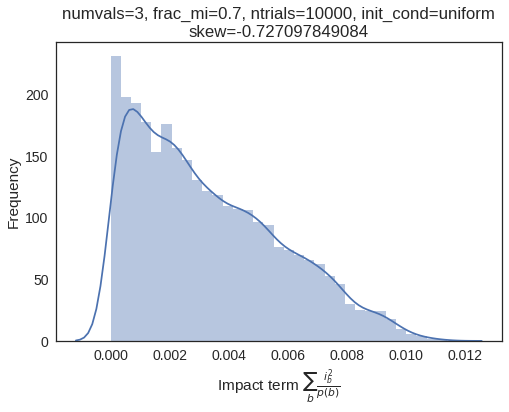

In [119]:
sns.distplot(impact_terms)
sns.plt.xlabel('Impact term $\\sum_b \\frac{i_b^2}{p(b)}$')
sns.plt.ylabel('Frequency')
sns.plt.title('numvals=%s, frac_mi=%s, ntrials=%s, init_cond=%s\nskew=%s' % (numvals, f, ntrials, init_cond, ss.skew(map(float, np.subtract(mi_after, mi_before)))))
sns.plt.savefig(figname('dist_impactterm'))
sns.plt.show()

In [129]:
print 'note: the std of MI of causal case is %s whereas the 0-std of impact term is %s (ratio %s)' % (np.std(mi_diff), np.sqrt(np.mean(np.power(impact_terms, 2))), np.std(mi_diff) / np.sqrt(np.mean(np.power(impact_terms, 2))))

note: the std of MI of causal case is 0.00606732727506 whereas the 0-std of impact term is 0.00414009554852 (ratio 1.46550416626)


Observation: for growing 'epsilon' the relative contribution of the impact term grows quite fast, and for epsilon=0.05 I find this to be around 2/3 whereas for epsilon=0.001 I saw something like 220 and for epsilon=0.01 I saw I think 33. Hand-sketch below suggests even faster than exponential. From about epsilon>=0.01 the effects seem to become measurable in the MI distribution.

Nevertheless, this creates technically a tension with the analytical derivation. 'epsilon' should theoretically be very small in order for some approximations to hold true. But it should not be too small in order for its effects to become measurable in the MI distribution. Hopefully then the analytical derivation will 'still hold' even if the nudges become larger.

In [135]:
1/1.5

0.6666666666666666

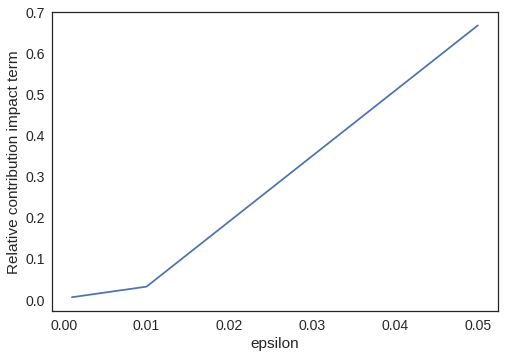

In [141]:
sns.plt.plot([0.001, 0.01, 0.05], np.divide(1, [220, 33, 1.5]))
# sns.plt.xscale('log')
# sns.plt.yscale('log')
sns.plt.xlabel('epsilon')
sns.plt.ylabel('Relative contribution impact term')
sns.plt.show()

## How to get such a right-sided ('triangle') distribution for impact term?

It seems due to the fact that each impact term $i_b$ is uniformly distributed and sums to some total expected impact, see third plot below.

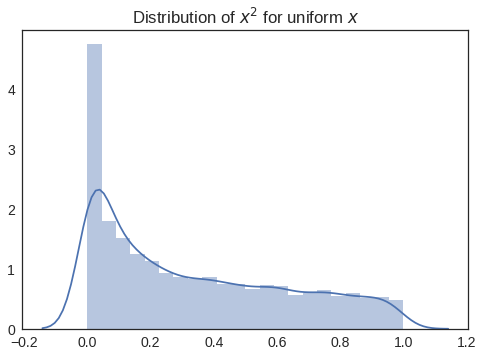

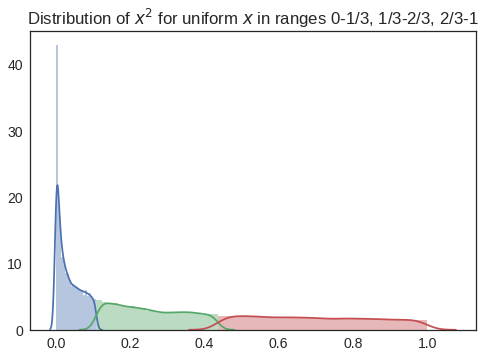

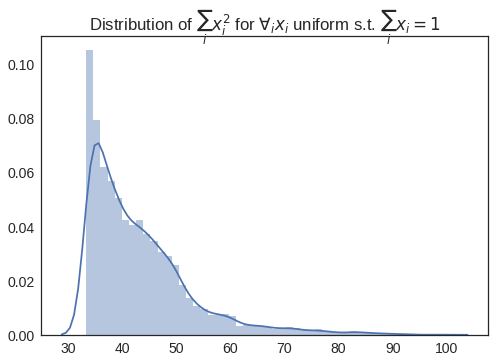

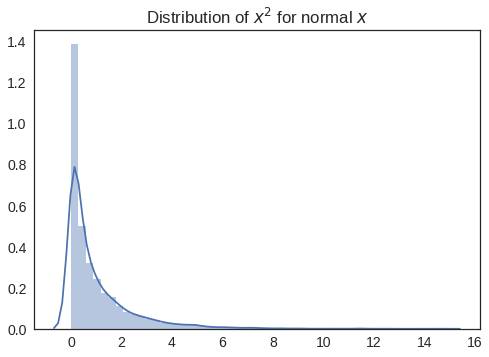

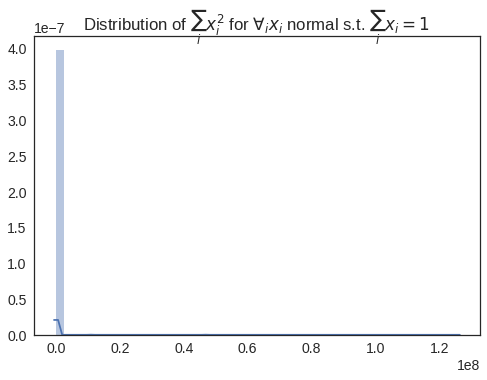

In [142]:
sns.distplot(np.power(np.random.uniform(size=ntrials), 2))
sns.plt.title('Distribution of $x^2$ for uniform $x$')
sns.plt.show()
sns.plt.title('Distribution of $x^2$ for uniform $x$ in ranges 0-1/3, 1/3-2/3, 2/3-1')
sns.distplot(np.power(np.random.uniform(0, 0.33, size=ntrials), 2))
sns.distplot(np.power(np.random.uniform(0.33, 0.66, size=ntrials), 2))
sns.distplot(np.power(np.random.uniform(0.66, 1, size=ntrials), 2))
sns.plt.show()
ims = np.random.uniform(size=(ntrials, numvals))
sns.distplot(np.sum(np.power(ims / np.reshape(np.repeat(np.sum(ims, axis=1) * 0.1, numvals), (ntrials, numvals)), 2), axis=1))
sns.plt.title('Distribution of $\\sum_i x_i^2$ for $\\forall_i x_i$ uniform s.t. $\\sum_i x_i = 1$')
sns.plt.savefig('./figures/dist_unisq_nv%s_f%s_ntrials%s_init-%s_nudge-%s.png' % (numvals, f, ntrials, init_cond, nudge_method))
sns.plt.show()
sns.distplot(np.power(np.random.randn(ntrials), 2))
sns.plt.title('Distribution of $x^2$ for normal $x$')
sns.plt.show()
ims = np.random.normal(0, 1, size=(ntrials, numvals))
sns.distplot(np.sum(np.power(ims / np.reshape(np.repeat(np.sum(ims, axis=1), 3), (ntrials, numvals)), 2), axis=1))
sns.plt.title('Distribution of $\\sum_i x_i^2$ for $\\forall_i x_i$ normal s.t. $\\sum_i x_i = 1$')
sns.plt.show()

# Skewness as function of sample size (ntrials)

In [8]:
szs = np.arange(10, 500, 5)
skewps = [ss.skewtest(np.random.lognormal(size=s))[1] for s in szs]

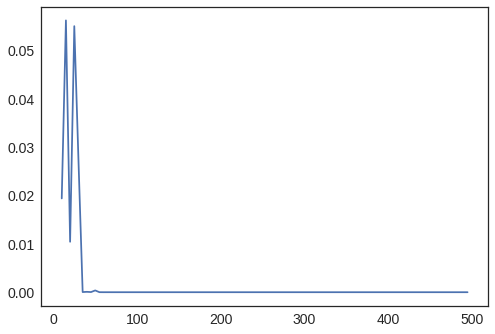

In [9]:
sns.plt.plot(szs, skewps)
sns.plt.show()

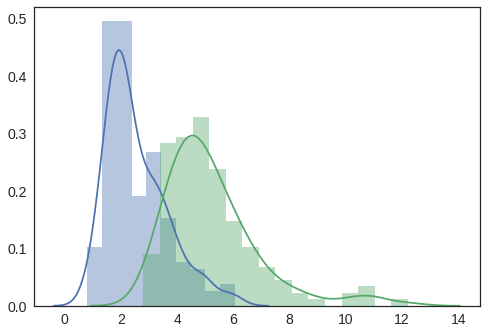

note: for a sample of 50 numbers the skewness is mean=5.2375139256 and quantiles=[4.179215057782943, 4.7987161236450309, 5.8150464345774342]
note: for a sample of 2500 numbers the skewness is mean=5.2375139256 and quantiles=[4.179215057782943, 4.7987161236450309, 5.8150464345774342]


In [5]:
skews = [ss.skew(np.random.lognormal(size=50)) for _ in xrange(150)]

sns.distplot(skews)
# sns.plt.show()

skews = [ss.skew(np.random.lognormal(size=50*50)) for _ in xrange(150)]

sns.distplot(skews)
sns.plt.show()

print 'note: for a sample of 50 numbers the skewness is mean=%s and quantiles=%s' % (np.mean(skews), [np.percentile(skews, p) for p in (25, 50, 75)])
print 'note: for a sample of 2500 numbers the skewness is mean=%s and quantiles=%s' % (np.mean(skews), [np.percentile(skews, p) for p in (25, 50, 75)])

Apparently it makes quite a big, structural difference for sample sizes in the range 0-10000 regarding the skewness value that is estimated!

In [25]:
ntrials_list = map(int, np.linspace(50, 50000, 50))

def worker(nt):
    return [ss.skew(np.random.lognormal(size=int(nt))) for _ in xrange(300)]

pool = mp.Pool(mp.cpu_count() - 1)

skews_per_ntrials = pool.map(worker, ntrials_list)

In [26]:
analytical_skew = (np.exp(1**2) + 2) * np.sqrt(np.exp(1**2) - 1)
print analytical_skew

6.18487713863


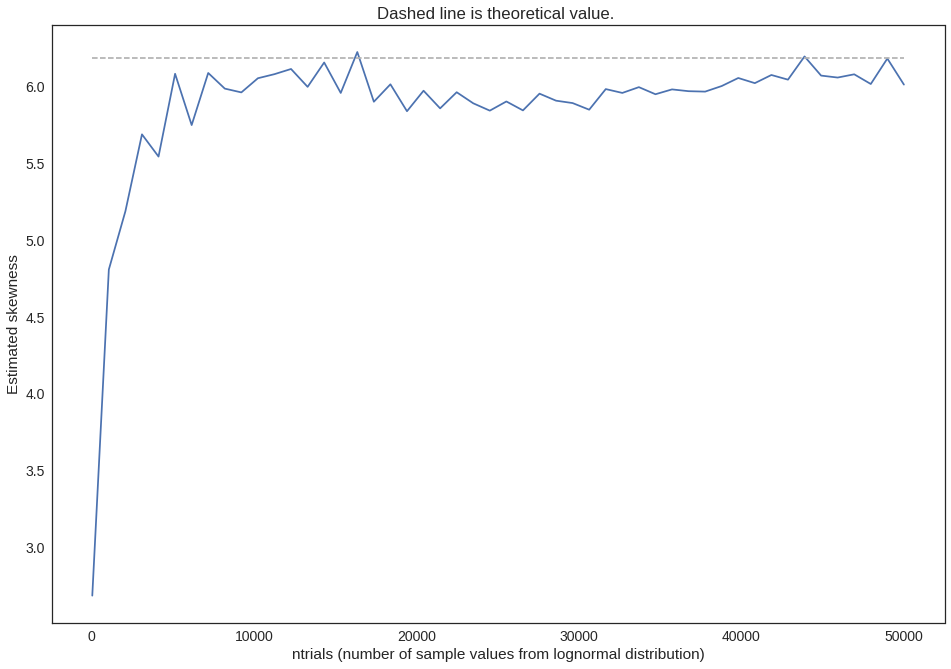

In [28]:
sns.plt.figure(figsize=(16,11))
sns.plt.plot(ntrials_list, np.mean(skews_per_ntrials, axis=1))
sns.plt.plot(ntrials_list, [analytical_skew]*len(ntrials_list), '--', color='0.7')
sns.plt.xlabel('ntrials (number of sample values from lognormal distribution)')
sns.plt.ylabel('Estimated skewness')
sns.plt.title('Dashed line is theoretical value. ')
sns.plt.show()

That is, for the standard lognormal distribution you seem to need at least 5000 and preferably >10000 samples in order to have a skewness estimate which gets close to the true value.

In [10]:
# lognormal serves as fake but skewed distribution of 'impact'
std_impact_term = np.std(np.random.lognormal(size=100000))  
print std_impact_term

2.14310914428


In [30]:
# removed: I think this makes no sense:
# ntrials_list = map(int, np.linspace(50, 50000, 20))  # number of impact and correlation term values
# ratio_stds = 0.002
# num_skew_samples_list = map(int, np.linspace(100, 10000, 10))
# skews_per_ntrials_nsamples = [[[ss.skew(np.random.normal(0, std_impact_term / ratio_stds, size=nt) - np.random.lognormal(size=nt)) 
#                                 for _ in xrange(num_skew_samples)] 
#                                for nt in ntrials_list] 
#                               for num_skew_samples in num_skew_samples_list]

ntrials_list = map(int, np.linspace(50, 100000, 30))  # number of impact and correlation term values
# ratio_stds = 0.002
# 0.002 was observed for numvals=4; 
# question is: how far up does this ratio have to go before we detect skewness in MI?
ratio_stds_list = np.linspace(0.002, 2, 3 * (mp.cpu_count() - 1))  
num_skew_samples = 250  # the higher this value, the smoother the curves, but otherwise has little meaning

def worker(ratio_stds):
    return [[ss.skew(np.random.normal(0, std_impact_term / ratio_stds, size=nt) - np.random.lognormal(size=nt)) 
             for _ in xrange(num_skew_samples)] 
            for nt in ntrials_list]

pool = mp.Pool(mp.cpu_count() - 1)

time_before = time.time()

skews_per_ntrials_ratios = pool.map(worker, ratio_stds_list)

print 'note: time taken in seconds:', time.time() - time_before

note: time taken in seconds: 226.62451601


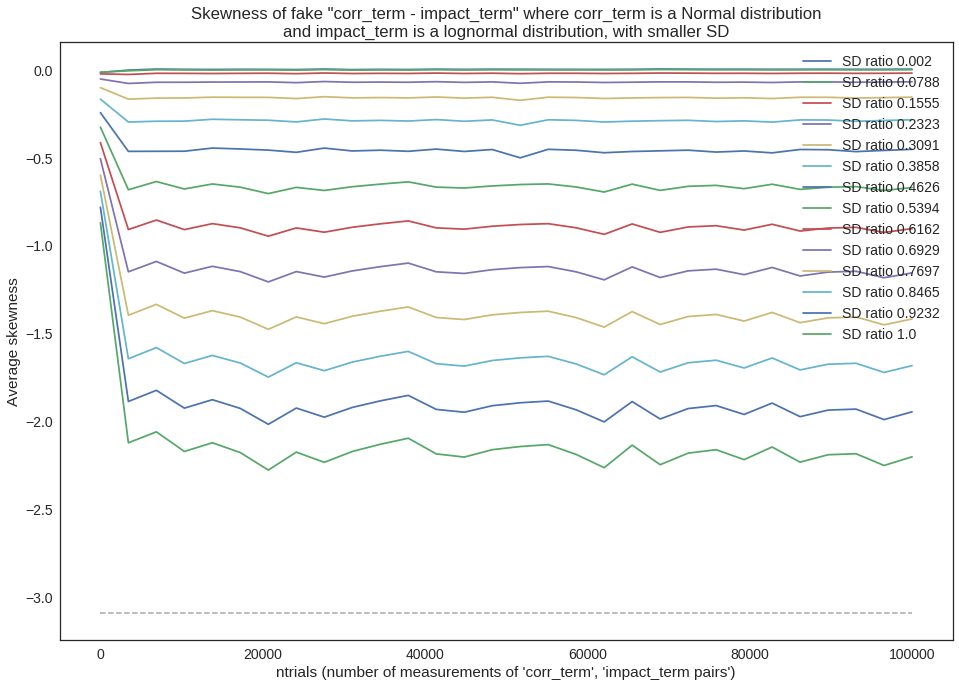

In [39]:
sns.plt.figure(figsize=(16,11))
for ix, skews_per_ntrials in enumerate(skews_per_ntrials_ratios):
    sns.plt.plot(ntrials_list, np.mean(skews_per_ntrials, axis=1), label='SD ratio ' + str(round(ratio_stds_list[ix], 4)))
sns.plt.title('Skewness of fake "corr_term - impact_term" where corr_term is a Normal distribution\nand impact_term is a lognormal distribution, with smaller SD')
sns.plt.xlabel('ntrials (number of measurements of \'corr_term\', \'impact_term pairs\')')
sns.plt.ylabel('Average skewness')
sns.plt.legend(loc='upper right')
sns.plt.plot(ntrials_list, [-float(max(ratio_stds_list)) / (1.0 + float(max(ratio_stds_list))) * analytical_skew]*len(ntrials_list), '--', color='0.7')
sns.plt.show()

*Conclusion:* the above plot shows that it is indeed possible for MI after a nudge to have a detectable skewness due to the impact term, but the SD of the impact term should grow to something like at least 1/4 of the correlation term. For numvals=4 I found it was 0.002, so the question is in which conditions would this actually occur? Still an open question.

# So how does the SD ratio behave in nudged pdfs?

In [ ]:
def worker(f, recurse=0):
    pdf = jp.JointProbabilityMatrix(1, numvals, 'uniform')
    
    if f > 0:
        try:
            pdf.append_variables_with_target_mi(1, f * pdf.entropy(), 
                                                num_repeats=int((numvals - 1) / 2) + 1)
        except UserWarning as e:
            assert 'num_repeats' in str(e)
            
            if recurse < 10:
                return worker(f, recurse=recurse + 1)
            else:
                pdf.append_independent_variables(pdf)
                
                raise UserWarning(e)
    else:
        pdf.append_independent_variables(pdf)

    nudge, impact, pdf_after = pdf.susceptibility_local_single(0, 1, epsilon, 
                                                               impact_measure='prob', 
                                                               ntrials=ntrials,
                                                               also_return_pdf_after=True)

    return nudge, impact, pdf, pdf_after
    

In [2]:
ss.pearsonr([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

(-1.0, 0.0)